# Notes

**Important**

This notebook was created on *April 23, 2024, at 19:08*  with the intention of providing detailed explanations and interpretations of the processes involved. While Python scripts are powerful, they can sometimes be complex and require a significant investment in terms of analysis and understanding. This document aims to simplify this task by breaking down and explaining each code segment in detail.

In this notebook, we will undertake to revisit and detail the implementations of the MNIST dataset, a dataset widely used in the machine learning community, initially popularized by Yann LeCun. The goal is to implement two types of neural architectures: a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN). We will then compare their performances through various metrics.

Additionally, special attention will be given to visualizing backpropagation to identify the global optimum. This approach aims to illustrate not only how modifications to the weights affect model accuracy during training but also to demonstrate optimization dynamics in action.

This work is essential for those looking to deepen their understanding of deep learning fundamentals as well as for those wishing to refine their ability to optimize machine learning algorithms.

## Setup

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

In [2]:
# Load data
train_data = torchvision.datasets.MNIST(root='data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_data = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor()
)

print('Data are ready!')

Data are ready!


We have downloaded the data, now to extract the images and labels we will type the following command:

```bash
X = train_data.data
y = train_data.targets
```

In [3]:
# Examples
# Images are in uint8
print(f'The label ==> {train_data.targets[0]}')
train_data.data[0]

The label ==> 5


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Preparation

We are going to prepare the images here. The images are already in an appropriate format and require no special preparation other than normalization. As you may notice, the pixel values range from 0 to 255. This range can increase the computational load and introduce significant variance. Therefore, it is crucial to normalize the data. Using a MinMaxScaler normalization could be beneficial to scale our data from 0 to 1.

The MinMax normalization formula is given by: $MinMax = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$.

Next, we will load these normalized data into a DataLoader, which will compact our data and organize it into batches. This will enable us to use the GPU for computations, making the process more efficient.

In [4]:
# Store the data
# Print dimension of the data
print(f'train_data ==> {train_data.data.shape}')
print(f'test_data ==> {test_data.data.shape}')

train_data ==> torch.Size([60000, 28, 28])
test_data ==> torch.Size([10000, 28, 28])


In [5]:
def plot_images_grid_from_dataset(dataset, num_images=25, title=None):
    """
    Plots a grid of images with labels directly from the dataset.

    Args:
    dataset (torch.utils.data.Dataset): Dataset from which to load the data.
    num_images (int): Number of images to display in the grid.
    title (str): Title of the plot.
    """
    if len(dataset) < num_images:
        raise ValueError("The dataset contains fewer images than the number requested for display.")
    
    # Manually fetch a batch of images and labels
    images = []
    labels = []
    for i in range(num_images):
        image, label = dataset[i]
        images.append(image)
        labels.append(label)
    
    # Convert lists to tensor
    images = torch.stack(images)
    labels = torch.tensor(labels)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(images, normalize=True, scale_each=True)

    # Show images
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)  # Rearrange the order of channels
    plt.axis('off')
    
    # Adding the title
    if title:
        plt.title(title)

    # Show labels in the title or a legend (optional)
    labels_str = ', '.join(map(str, labels.tolist()))
    plt.xlabel(f"Labels: {labels_str}")

    plt.show()

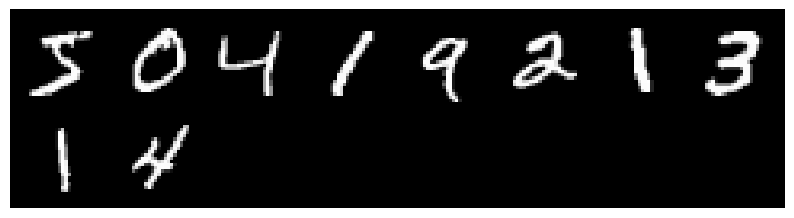

In [6]:
plot_images_grid_from_dataset(train_data, num_images=10)

These results indicate that our dataset contains 60,000 images, each with a height and width of 28 pixels. The structure of these data in a three-dimensional tensor (observations, height, width) also reveals that the images are in black and white, using a single channel. For color images, the tensor structure would include a fourth dimension corresponding to the color channels.

Let's move on to normalization:
The pixel values range from 0 to 255. Since the minimum value 
𝑋_min
X_min is zero, we can simplify the normalization by merely dividing each pixel by 255. This operation scales the pixel values to the range [0, 1], which is often required to optimize the performance of machine learning algorithms.

In [7]:
# Normalization
train_data.data = train_data.data / 255.0
test_data.data = test_data.data / 255.0

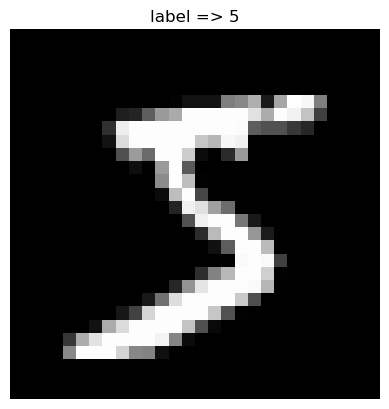

In [8]:
plt.title(f'label => {train_data.targets[0].numpy()}')
plt.axis('off')
plt.imshow(train_data.data[0], cmap='gray')

In [9]:
# Injection
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

## Modeling

In [10]:
# Choose the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In this section, we will explore the design and implementation of neural network models, which are essentially assemblies of functions $f(x)$ working together to solve complex problems through the aggregation of their predictions. The origins of neural networks date back to the 1960s with the introduction of the perceptron by Frank Rosenblatt. This model is described by the equation $y = W \cdot X + b$, where $W$ represents the weights, $X$ the inputs, and $b$ the bias. However, despite this innovation, the perceptron was limited to solving linear problems due to its fundamental structure.

The advent of the 1980s and 1990s saw significant advancements in this field thanks to the work of Geoffrey Hinton and others, who developed the MultiLayer Perceptron (MLP). The MLP is a network composed of multiple layers of perceptrons, enabling it to capture complex nonlinearities and handle problems well beyond the capabilities of the simple perceptron. This enhanced ability makes the MLP particularly effective for a variety of applications ranging from image recognition to predictive modeling in financial and medical domains.

We will now proceed to the practical implementation of an MLP. This model, structured in successive layers of neurons with nonlinear activations, allows for modeling complex relationships between inputs and desired outputs. Achieving this objective involves a deep understanding of the underlying principles of tensor calculus, gradients, and backpropagation—crucial elements for the effective training of neural networks.

This exploration is set within a context of ongoing research where neural network models are constantly refined to improve their accuracy, efficiency, and applicability to an increasingly broad array of complex challenges across various scientific and engineering fields. Thus, the development of MLPs is not just a technical task but also a quest to extend the boundaries of what machines can learn to do from data.

In [33]:
def Trainer(dataloader, validloader, model, criterion, optimizer, epochs=10):
    """
    This function allows you to train a model using training data sets (dataloader) while evaluating its performance on validation data.
    Using tqdm (taqadum) provides a visual progress bar to track training and assessment progress.
    A separate progress bar is used for each training epoch, showing progress across training batches, as well as a separate progress bar for evaluation on validation data.
    ---
    We return two lists, loss_cache and valid_cache, which respectively contain the average training losses for each epoch and the evaluation results on the validation data,
    such as average loss and accuracy.
    """
    size = len(dataloader)
    model = model.to(device)
    model.train()
    loss_cache = []
    valid_cache = []
    acc = []
    loss_test = []
    training_time = []

    for i in range(epochs):
      total_loss = 0
      start_time = time.time()

      for batch, (X, y) in enumerate(tqdm(dataloader, desc='Progress')):
        # compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = criterion(preds, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

      # Time calcul
      end_time = time.time()
      train_time = end_time - start_time
      training_time.append(train_time)

      # Calculate loss
      avg_loss = total_loss / size
      loss_cache.append(avg_loss)
      print(f"\nEpoch [{i + 1}/{epochs}] - Avg Training Loss: {avg_loss:.6f}")

      # Evaluation on validation set
      model.eval()
      total_correct = 0
      total_test_loss = 0

      with torch.no_grad():
        for X_val, y_val in validloader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          preds_val = model(X_val)
          total_test_loss += criterion(preds_val, y_val).item()
          total_correct += (preds_val.argmax(1) == y_val).type(torch.float).sum().item()


      avg_test_loss = total_test_loss / len(validloader)
      accuracy = total_correct / len(validloader.dataset)
      acc.append(accuracy)
      loss_test.append(avg_test_loss)
      valid_cache.append({"test_loss": loss_test, "accuracy": acc})

      # Print loss and accuracy for the valid loader
      print(f"Validation - Avg Loss: {avg_test_loss:.6f} | Accuracy: {accuracy * 100:.2f}%\n")

    # Time for the training
    total_time = sum(training_time)
    print("Total training time for {} epochs: {:.2f} seconds".format(epochs, total_time))

    return loss_cache, valid_cache

In [34]:
# Perform a Perceptron
class Perceptron(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Perceptron, self).__init__()
        # Ensure the input dimension is correctly provided
        self.y = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        # Flatten x inside the model if not already flattened
        x = x.view(x.size(0), -1)
        x = self.y(x)
        x = F.softmax(x, dim=1)
        return x


In [35]:
# Assuming input dimensions for MNIST (28x28 images)
input_dim = 28 * 28
num_classes = 10

Perceptron = Perceptron(input_dim, num_classes)
print(Perceptron)

Perceptron(
  (y): Linear(in_features=784, out_features=10, bias=True)
)


In [36]:
#parameters
lr = 0.001

# Define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Perceptron.parameters(), lr = lr, momentum=0.9)

In [37]:
loss_cahe, valid_cache = Trainer(train_loader, test_loader, Perceptron, criterion, optimizer)

Progress: 100%|██████████| 1875/1875 [00:04<00:00, 414.80it/s]



Epoch [1/10] - Avg Training Loss: 2.274715
Validation - Avg Loss: 2.250776 | Accuracy: 23.77%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 435.70it/s]



Epoch [2/10] - Avg Training Loss: 2.230123
Validation - Avg Loss: 2.215319 | Accuracy: 28.16%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 412.92it/s]



Epoch [3/10] - Avg Training Loss: 2.200301
Validation - Avg Loss: 2.193168 | Accuracy: 32.34%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 440.59it/s]



Epoch [4/10] - Avg Training Loss: 2.179284
Validation - Avg Loss: 2.171745 | Accuracy: 40.62%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 450.86it/s]



Epoch [5/10] - Avg Training Loss: 2.157935
Validation - Avg Loss: 2.148861 | Accuracy: 44.37%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 422.71it/s]



Epoch [6/10] - Avg Training Loss: 2.136497
Validation - Avg Loss: 2.127378 | Accuracy: 45.53%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 433.35it/s]



Epoch [7/10] - Avg Training Loss: 2.117449
Validation - Avg Loss: 2.109631 | Accuracy: 46.03%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 427.20it/s]



Epoch [8/10] - Avg Training Loss: 2.101713
Validation - Avg Loss: 2.095159 | Accuracy: 46.79%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 438.47it/s]



Epoch [9/10] - Avg Training Loss: 2.088776
Validation - Avg Loss: 2.083102 | Accuracy: 47.27%



Progress: 100%|██████████| 1875/1875 [00:04<00:00, 444.16it/s]



Epoch [10/10] - Avg Training Loss: 2.077839
Validation - Avg Loss: 2.072970 | Accuracy: 47.50%

Total training time for 10 epochs: 43.45 seconds


In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.hl_1 = nn.Linear(hidden_size, hidden_size) 
        self.out = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.input(x))
        x = self.relu(self.hl_1(x))
        x = self.out(x) 
        return F.softmax(x, dim=1) 